# Выбор локации для скважины

# Описание исследования.
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Цель исследования.

- Определелить регион, где добыча принесёт наибольшую прибыль.

# Задачи исследования.

- Подготовить и изучить данные
- На основе данных обучить и проверить модель.
- С помощью полученной модели определить регион с наибольшей прибылью по добыче.

# Исходные данные.
id — уникальный идентификатор скважины;<br>
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);<br>
product — объём запасов в скважине (тыс. баррелей), целевой признак. <br>

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

# Этапы выполнения проекта
***Часть 1. Загрузка, изучение и подготовка данных.***
 - [Загрузка и подготовка данных](#Загрузка-и-подготовка-данных)
 
***Часть 2. Исследовательский анализ данных.***
 - [Исследовательский анализ данных](#Исследовательский-анализ-данных) 
 - [Анализ распределения входных признаков от целевого](#Анализ-распределения-входных-признаков-от-целевого)
 
***Часть 3. Обучение и проверка модели.***
 - [Обучение и проверка модели](#Обучение-и-проверка-модели)
 
***Часть 4. Подготовка и расчёт прибыли.***
 - [Подготовка к расчёту прибыли](#Подготовка-к-расчёту-прибыли)
 - [Расчёт прибыли и рисков](#Расчёт-прибыли-и-рисков)
 
 - [Чек-лист готовности проекта](#Чек-лист-готовности-проекта)

## Загрузка и подготовка данных

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [54]:
df_one = pd.read_csv('/datasets/geo_data_0.csv') # данные геологоразведки 1-го региона
df_two = pd.read_csv('/datasets/geo_data_1.csv') # данные геологоразведки 2-го региона
df_three = pd.read_csv('/datasets/geo_data_2.csv') # данные геологоразведки 3-го региона

In [55]:
# Константы
BUDGET = 10_000_000_000  # рублей
PRICE_PER_BARREL = 450  # рублей за баррель
REVENUE_PER_THOUSAND_BARRELS = PRICE_PER_BARREL * 1000  # цена за 1 тыс. баррелей, руб.
TOP_WELLS = 200  # количество скважин для разработки

## Предобработка данных

</font><font color='Blue'><b>Изучим данные</b></font><br>

In [56]:
# данные геологоразведки 1-го региона
df_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [57]:
df_one.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [58]:
df_one.tail()

,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


In [59]:
# дубликаты
df_one.duplicated().sum()

0

<div style="background-color: #e7f5ff; padding: 10px;">  
    Таблица df_one имеет 5 колонок. 100 000 строк, пропусков нет. Дубликатов нет. Типы данных соответствуют значениям.
</div>

In [60]:
# данные геологоразведки 2-го региона
df_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [61]:
df_two.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [62]:
df_two.tail()

,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


In [63]:
# дубликаты
df_two.duplicated().sum()

0

<div style="background-color: #e7f5ff; padding: 10px;">  
   Таблица df_two имеет 5 колонок. 100 000 строк, пропусков нет. Дубликатов нет. Типы данных соответствуют значениям. 
</div>

In [64]:
# данные геологоразведки 3-го региона
df_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [65]:
df_three.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [66]:
df_three.tail()

,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


In [67]:
# дубликаты
df_three.duplicated().sum()

0

<div style="background-color: #e7f5ff; padding: 10px;">  
   Таблица df_three имеет 5 колонок. 100 000 строк, пропусков нет. Дубликатов нет. Типы данных соответствуют значениям. 
</div>

<div style="background-color: #e7f5ff; padding: 10px; border-left: 3px solid #4dabf7;">  
 Вывод по предобработке:

- Таблица df_one имеет 5 колонок. 100 000 строк, пропусков нет. Дубликатов нет. Типы данных соответствуют значениям.
- Таблица df_two имеет 5 колонок. 100 000 строк, пропусков нет. Дубликатов нет. Типы данных соответствуют значениям.
- Таблица df_three имеет 5 колонок. 100 000 строк, пропусков нет. Дубликатов нет. Типы данных соответствуют значениям. 
</div>

## Исследовательский анализ данных

In [68]:
# данные геологоразведки 1-го региона
df_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [69]:
df_one.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [70]:
df_one.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<div style="background-color: #e7f5ff; padding: 10px;">  

- Значения "f0" находятся в диапазоне от -1.40 до 2.36, среднее 0.5, медианна 0.5. Аномалий нет.<br> 
- Значения "f1" находятся в диапазоне от -0.85 до 1.34, среднее 0.25, медианна 0.25. Аномалий нет. <br> 
- Значения "f2" находятся в диапазоне от -12.09 до 16.00, среднее 2.5, медианна 2.52. Аномалий нет.<br> 
- Значения "product" находятся в диапазоне от 0.00 до 185.36, среднее 92.5, медианна 91.85. Аномалий нет.<br>  
</div>

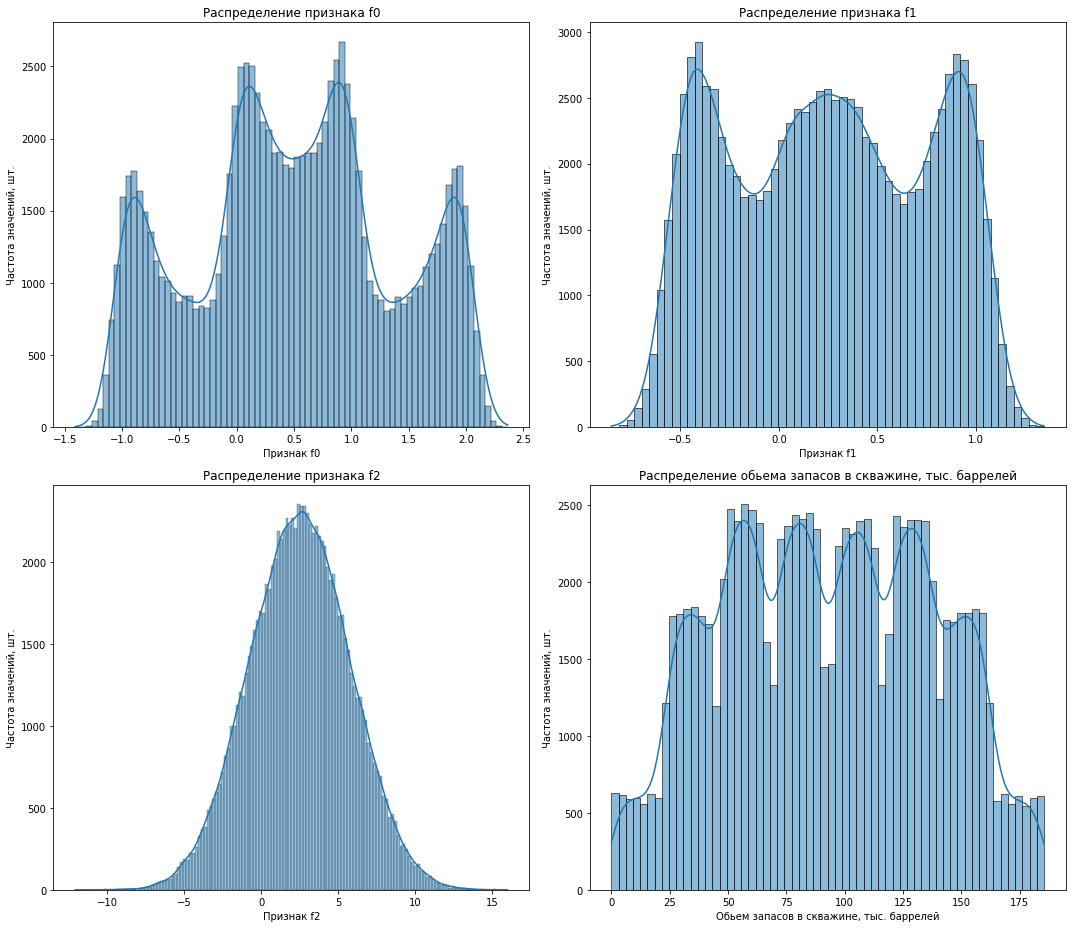

In [71]:
# Построим графики количественных признаков (непрерывные)
num_cols = ['f0', 'f1', 'f2', 'product']

# Словарь с подписями для графиков
labels_dict = {
    'f0': ["Распределение признака f0", "Признак f0", "Частота значений, шт."],
    'f1': ["Распределение признака f1", "Признак f1", "Частота значений, шт."],
    'f2': ["Распределение признака f2", "Признак f2", "Частота значений, шт."],
    'product': ["Распределение обьема запасов в скважине, тыс. баррелей", "Обьем запасов в скважине, тыс. баррелей", "Частота значений, шт."]
}

# Построение гистограмм с кастомными подписями
plt.figure(figsize=(15, 13))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_one[col], kde=True)

    # Получаем подписи из словаря
    title, xlabel, ylabel = labels_dict.get(col, [col, col, "Частота"])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.tight_layout()
plt.show()

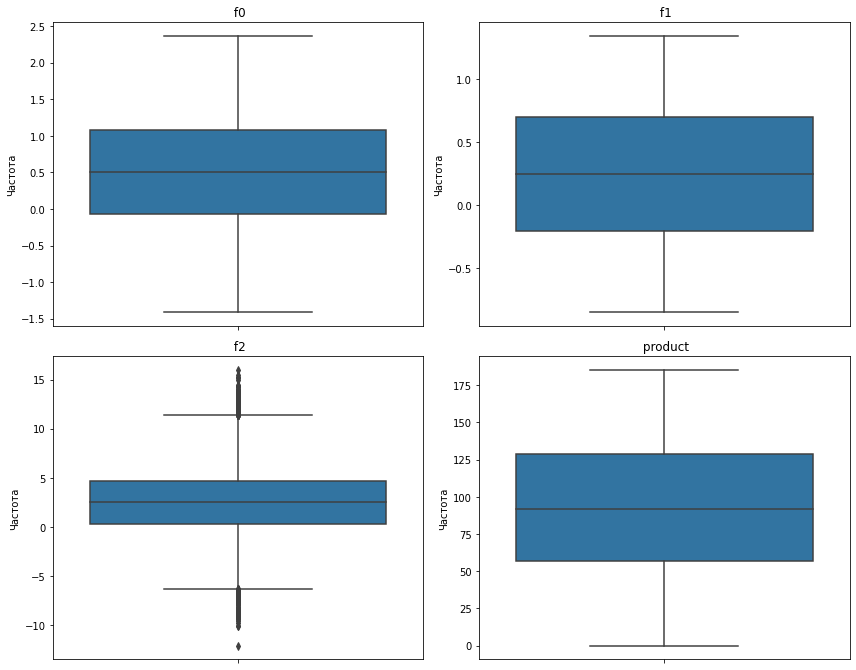

In [72]:
# ящики с усами с выбросами
plt.figure(figsize=(12, 14))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=df_one[col])
    plt.title(f' {col}')
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

<div style="background-color: #e7f5ff; padding: 10px;"> 
    
- Построим тепловую карту и проведем корреляционный анализ количественных признаков в таблице df_one для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.<br>

- Анализ проведем методом Пирсона, так как у нас непрерывные количественные данные и в их распределениях слабо, но заметна картина нормального распределения.<br>   
</div>

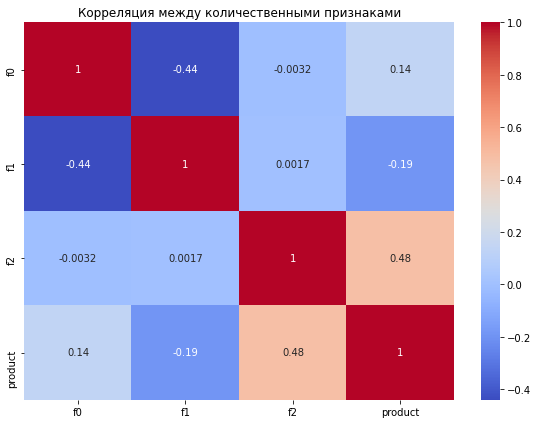

In [73]:
corr = df_one[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между количественными признаками')
plt.tight_layout()
plt.show()

<div style="background-color: #e7f5ff; padding: 10px;">  
    
- В матрице корреляции df_one, максимальное значение 0.48 (умеренная) между 'f2' и 'product', далее значение -0.44 (умеренная) между 'f1' и 'f0', далее -0.19 (слабая) между 'f1' и 'product', также из значимых значение 0.14 между 'f0' и 'product'. Мультиколлинеарности нет. 
</div>

In [74]:
# данные геологоразведки 2-го региона
df_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [75]:
df_two.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [76]:
df_two.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<div style="background-color: #e7f5ff; padding: 10px;">  

- Значения "f0" находятся в диапазоне от -31.61 до 29.42, среднее 1.14, медианна 1.15. Аномалий нет.<br> 
- Значения "f1" находятся в диапазоне от -26.36 до 18.73, среднее -4.80, медианна -4.81. Аномалий нет. <br> 
- Значения "f2" находятся в диапазоне от -0.02 до 5.02, среднее 2.49, медианна 2.01. Есть отклонение между средним и медианной.<br> 
- Значения "product" находятся в диапазоне от 0.00 до 137.95, среднее 68.83, медианна 57.09. Есть отклонение между средним и медианной.<br>  
</div>

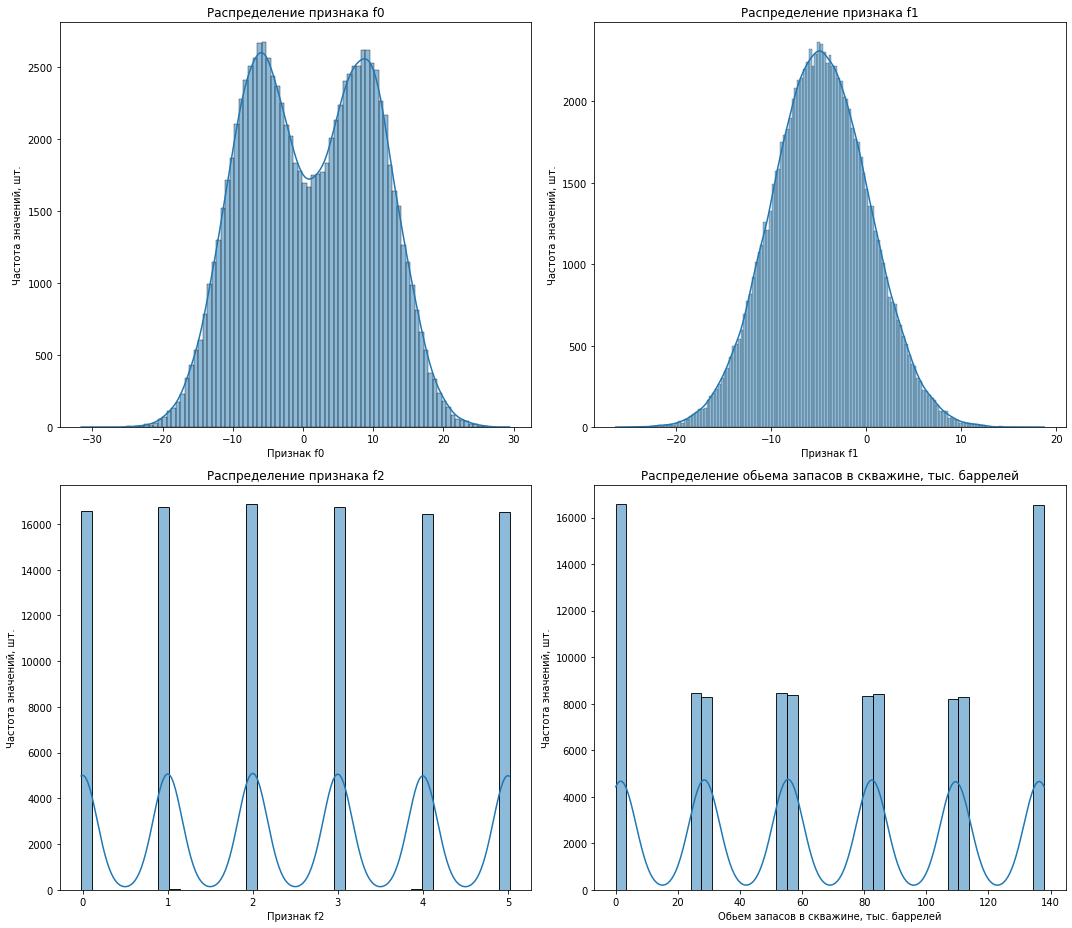

In [77]:
# Построим графики количественных признаков (непрерывные)
num_cols = ['f0', 'f1', 'f2', 'product']

# Словарь с подписями для графиков
labels_dict = {
    'f0': ["Распределение признака f0", "Признак f0", "Частота значений, шт."],
    'f1': ["Распределение признака f1", "Признак f1", "Частота значений, шт."],
    'f2': ["Распределение признака f2", "Признак f2", "Частота значений, шт."],
    'product': ["Распределение обьема запасов в скважине, тыс. баррелей", "Обьем запасов в скважине, тыс. баррелей", "Частота значений, шт."]
}

# Построение гистограмм с кастомными подписями
plt.figure(figsize=(15, 13))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_two[col], kde=True)

    # Получаем подписи из словаря
    title, xlabel, ylabel = labels_dict.get(col, [col, col, "Частота"])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.tight_layout()
plt.show()

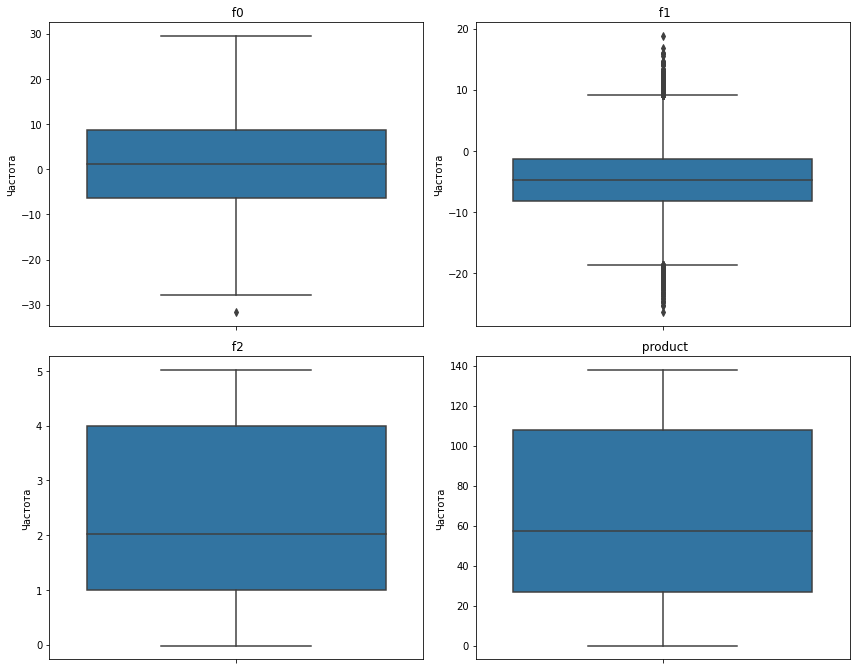

In [78]:
# ящики с усами с выбросами
plt.figure(figsize=(12, 14))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=df_two[col])
    plt.title(f' {col}')
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

<div style="background-color: #e7f5ff; padding: 10px;"> 
    
- Построим тепловую карту и проведем корреляционный анализ количественных признаков в таблице df_one для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.<br>

- Анализ проведем двумя методома Пирсона и Спирмана, так как у нас есть непрерывные количественные данные и они распределены нормально и есть вещественные данные в колонках 'f2' и 'product', но сконцентрированны вокруг целых чисел. Поэтому для сравнения оценим корреляцию еще методом Спирмана.<br>   
</div>

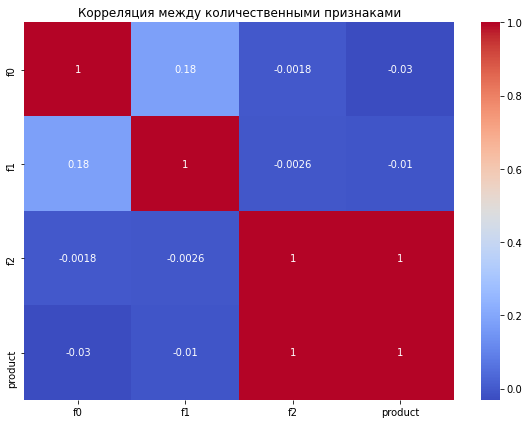

In [79]:
corr = df_two[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между количественными признаками')
plt.tight_layout()
plt.show()

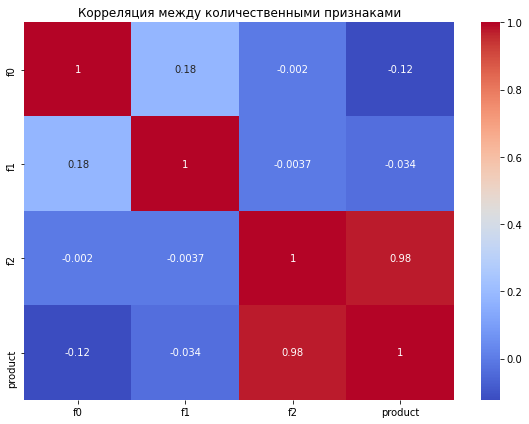

In [80]:
# сравним методом Спирмана
corr = df_two[num_cols].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между количественными признаками')
plt.tight_layout()
plt.show()

- В матрице корреляции df_two присутствует мультиколлинеарность между 'f2' и 'product'. По Пирсону 1, по Спирману 0.98. Эта зависимость будет сильно влиять на нашу будущую модель, но решим, что она не является следствием утечки данных и не будем удалять ее. Между 'f0' и 'f1' значение 0.18 (слабая) и между 'f0' и 'product' -0.12 (слабая). Остальные незначительны.
</div>

In [81]:
# данные геологоразведки 3-го региона
df_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [82]:
df_three.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [83]:
df_three.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<div style="background-color: #e7f5ff; padding: 10px;">  

- Значения "f0" находятся в диапазоне от -8.76 до 7.24, среднее 0.002, медианна 0.009. Аномалий нет.<br> 
- Значения "f1" находятся в диапазоне от -7.08 до 7.84, среднее -0.002, медианна -0.009. Аномалий нет. <br> 
- Значения "f2" находятся в диапазоне от -11.97 до 16.74, среднее 2.5, медианна 2.48. Аномалий нет.<br> 
- Значения "product" находятся в диапазоне от 0.00 до 190.03, среднее 95, медианна 94.93. Аномалий нет.<br>  
</div>

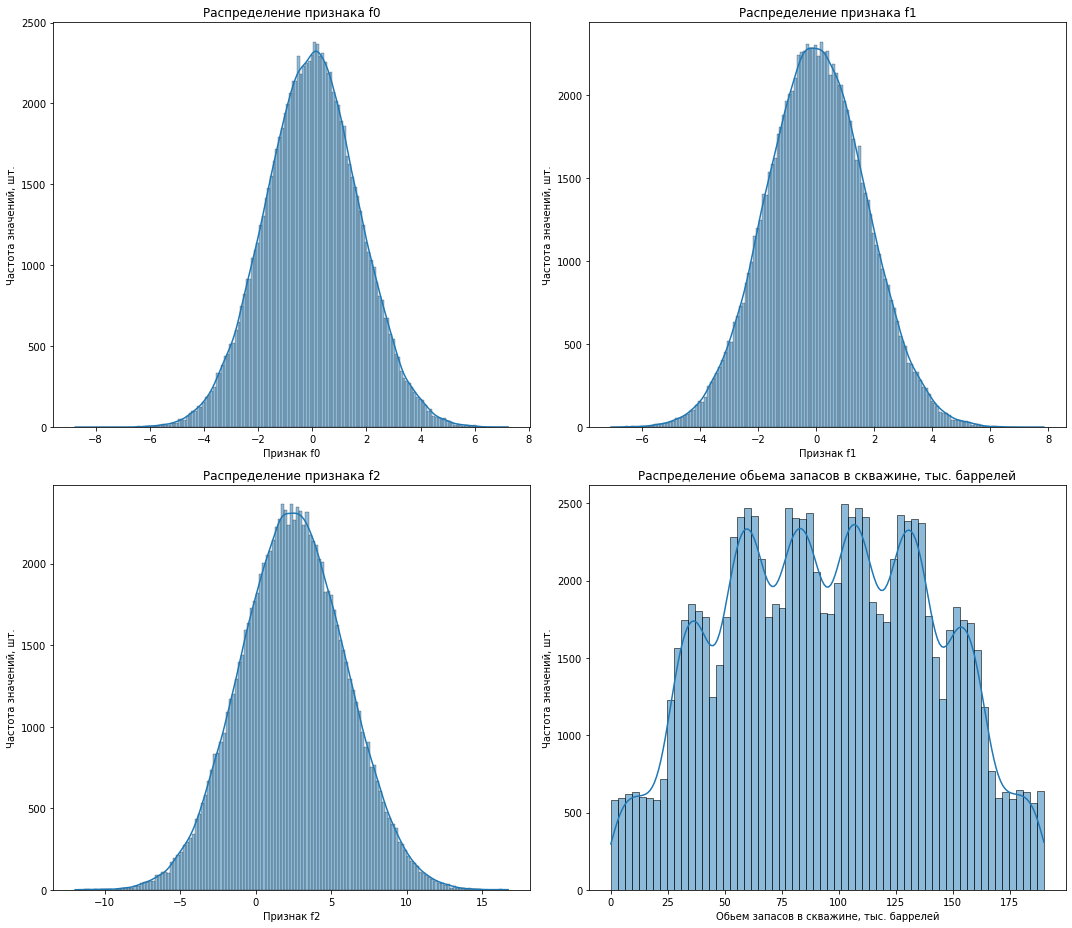

In [84]:
# Построим графики количественных признаков (непрерывные)
num_cols = ['f0', 'f1', 'f2', 'product']

# Словарь с подписями для графиков
labels_dict = {
    'f0': ["Распределение признака f0", "Признак f0", "Частота значений, шт."],
    'f1': ["Распределение признака f1", "Признак f1", "Частота значений, шт."],
    'f2': ["Распределение признака f2", "Признак f2", "Частота значений, шт."],
    'product': ["Распределение обьема запасов в скважине, тыс. баррелей", "Обьем запасов в скважине, тыс. баррелей", "Частота значений, шт."]
}

# Построение гистограмм с кастомными подписями
plt.figure(figsize=(15, 13))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_three[col], kde=True)

    # Получаем подписи из словаря
    title, xlabel, ylabel = labels_dict.get(col, [col, col, "Частота"])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.tight_layout()
plt.show()

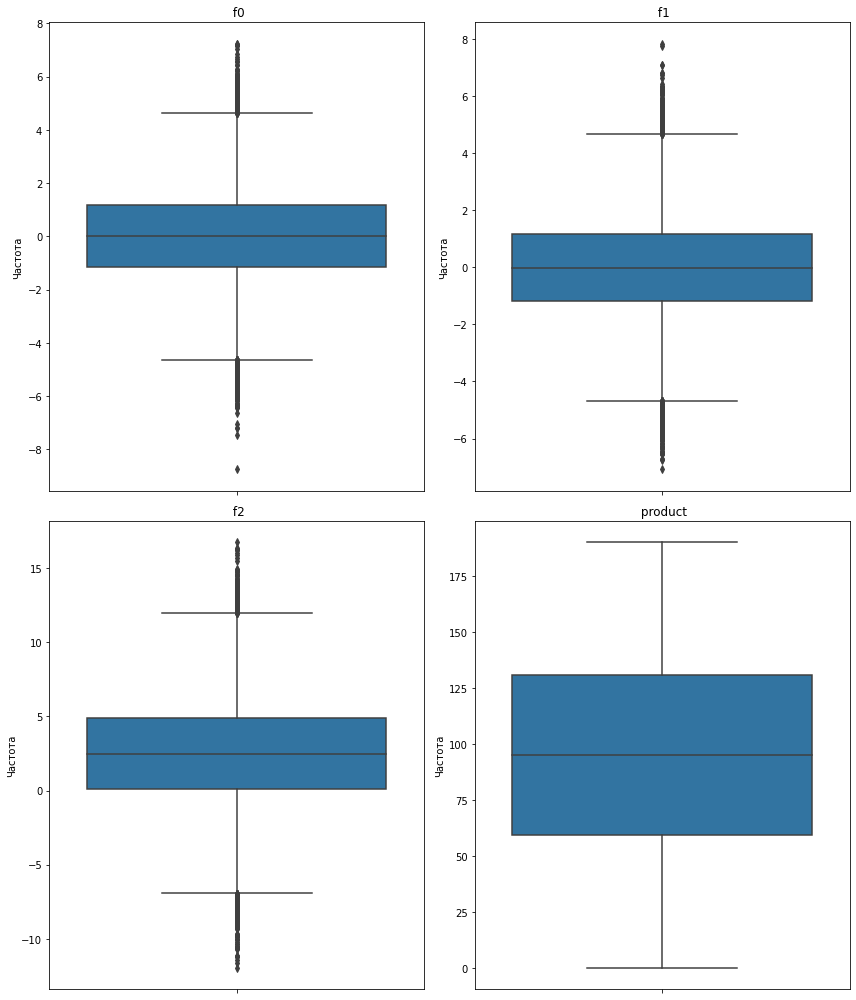

In [85]:
# ящики с усами с выбросами
plt.figure(figsize=(12, 14))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df_three[col])
    plt.title(f' {col}')
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

<div style="background-color: #e7f5ff; padding: 10px;"> 
    
- Построим тепловую карту и проведем корреляционный анализ количественных признаков в таблице df_three для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.<br>

- Анализ проведем методом Пирсона, так как у нас непрерывные количественные данные и их распределения  нормально распределенны.<br>   
</div>

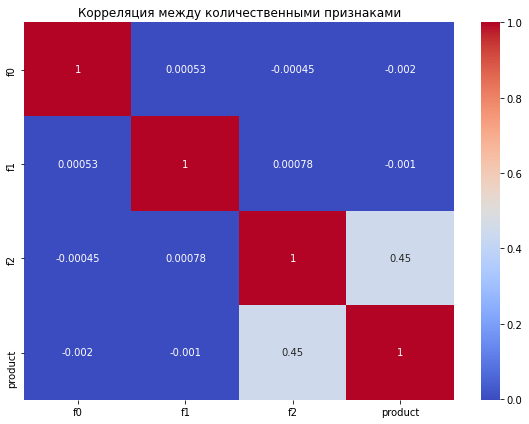

In [86]:
corr = df_three[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между количественными признаками')
plt.tight_layout()
plt.show()

<div style="background-color: #e7f5ff; padding: 10px;">  
    
- В матрице корреляции df_three, максимальное значение 0.45 (умеренная) между 'f2' и 'product', остальные незначительны. Мультиколлинеарности нет. 
</div>

## Анализ распределения входных признаков от целевого

<div style="background-color: #e7f5ff; padding: 10px;">  
    
- Проанализируем распределения входных признаков в зависимости от целевого признака в наших трех регионах ('product' — объём запасов в скважине (тыс. баррелей)). 
</div>

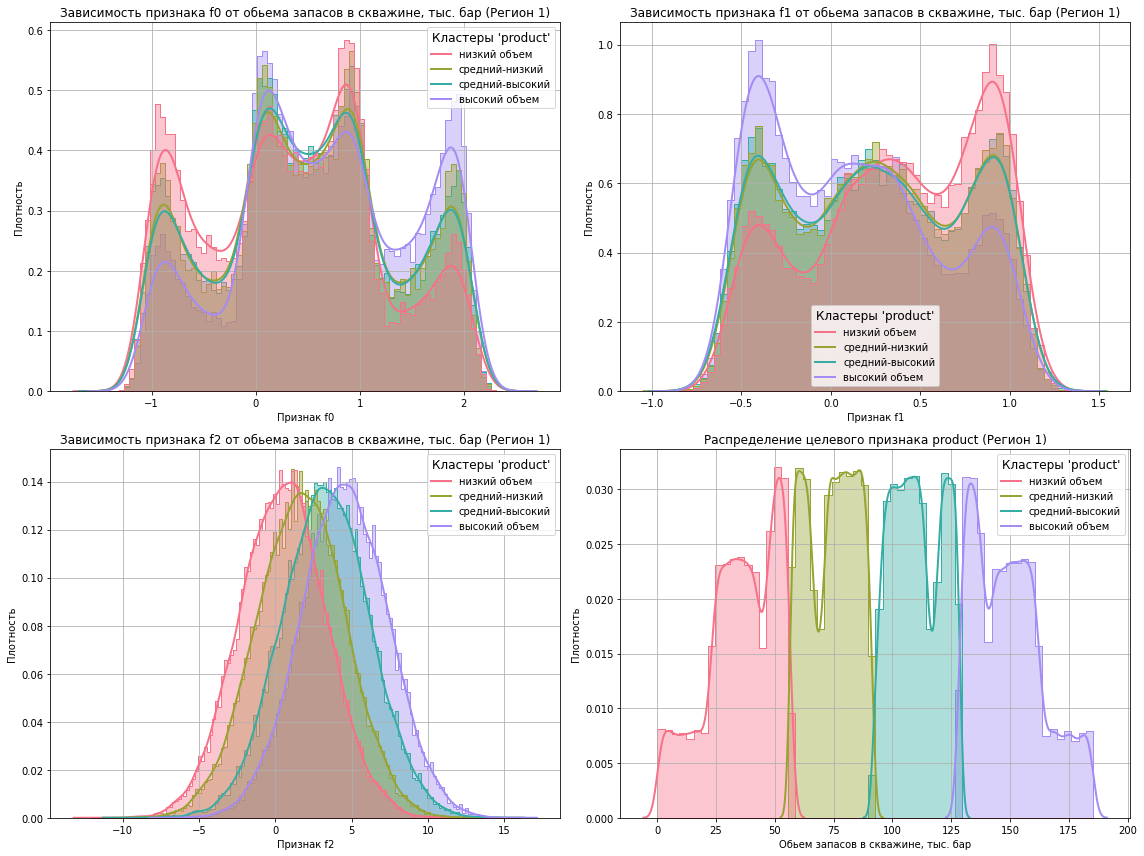

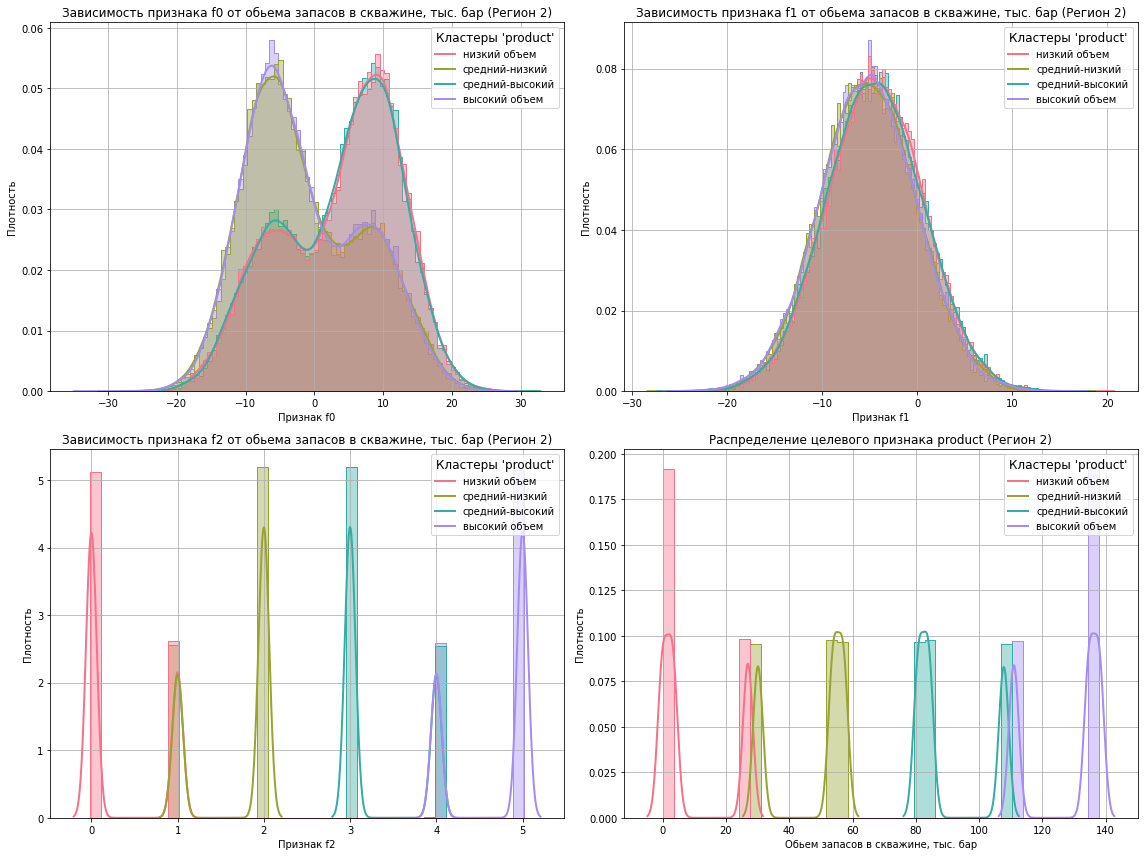

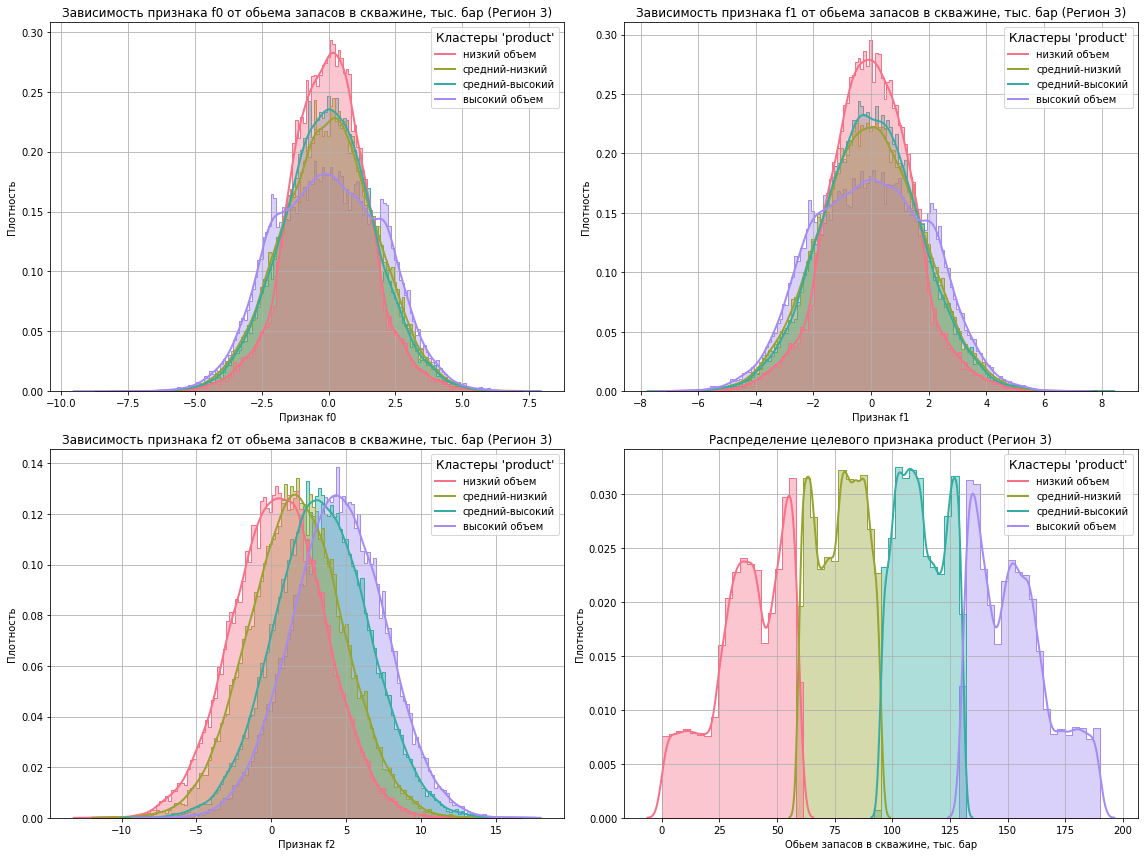

In [87]:
def plot_distribution_by_product_bin(df, region_name='Регион', q=4):
    
    num_cols = ['f0', 'f1', 'f2', 'product']

    # Разобьем данные 'product' на кластеры (Бины), для возможности построения графиков с большим обьемом данных
    df = df.copy()
    df['product_bin'] = pd.qcut(df['product'], q=q, labels=[
        'низкий объем', 'средний-низкий', 'средний-высокий', 'высокий объем'
    ])

    palette = sns.color_palette('husl', n_colors=q)
    bin_labels = df['product_bin'].cat.categories

    labels_dict = {
        'f0': ["Зависимость признака f0 от обьема запасов в скважине, тыс. бар", "Признак f0", "Плотность"],
        'f1': ["Зависимость признака f1 от обьема запасов в скважине, тыс. бар", "Признак f1", "Плотность"],
        'f2': ["Зависимость признака f2 от обьема запасов в скважине, тыс. бар", "Признак f2", "Плотность"],
        'product': ["Распределение целевого признака product", "Обьем запасов в скважине, тыс. бар", "Плотность"]
    }

    plt.figure(figsize=(16, 12))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(2, 2, i)

        # Гистограмма
        sns.histplot(
            data=df, 
            x=col,
            hue='product_bin',
            palette=palette,
            element='step',
            stat='density',
            common_norm=False,
            alpha=0.4,
            legend=False
        )

        # KDE-плотности
        for j, label in enumerate(bin_labels):
            subset = df[df['product_bin'] == label]
            sns.kdeplot(
                data=subset,
                x=col,
                color=palette[j],
                label=str(label),
                linewidth=2
            )

        title, xlabel, ylabel = labels_dict.get(col, [col, col, "Плотность"])
        plt.title(f"{title} ({region_name})")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.legend(title="Кластеры 'product'", title_fontsize=12, fontsize=10)

    plt.tight_layout()
    plt.show()

plot_distribution_by_product_bin(df_one, region_name='Регион 1')
plot_distribution_by_product_bin(df_two, region_name='Регион 2')
plot_distribution_by_product_bin(df_three, region_name='Регион 3')

<div style="background-color: #e7f5ff; padding: 10px; border-left: 3px solid #4dabf7;">  

 **Вывод по исследовательскому анализу.**
    
- df_one - данные геологоразведки 1-го региона

Данные в норме, аномалий нет. Распределение признака f2 имеет нормальное распределение.
Распределения признаков f0, f1 и product имеют распределение схожее с нормальным.

В матрице корреляции df_one, максимальное значение 0.48 (умеренная) между 'f2' и 'product', 
далее значение -0.44 (умеренная) между 'f1' и 'f0', далее -0.19 (слабая) между 'f1' и 'product',
также из значимых значение 0.14 между 'f0' и 'product'. Мультиколлинеарности нет.


- df_two - данные геологоразведки 2-го региона

Данные в норме, аномалий нет. Есть небольшие отклонение между средним и медианной в признаке f2 
и product.
Распределение признака f0 имеет нормальное распределение c двумя вершинами, признака f1 нормальное.
Распределения признаков f2 и product имеют распределение близкое к дискретному. Значение этих 
признаков сосредоточенны около нескольких значений.

В матрице корреляции df_two присутствует мультиколлинеарность между 'f2' и 'product'. По Пирсону 1, по Спирману 0.98. Эта зависимость будет сильно влиять на нашу будущую модель, но решим, что она не является следствием утечки данных и не будем удалять ее. Между 'f0' и 'f1' значение 0.18 (слабая) и между 'f0' и 'product' -0.12 (слабая). Остальные незначительны.

- df_three данные геологоразведки 3-го региона

Данные в норме, аномалий нет.
Распределения признаков f0, f1 и f2 имеют нормальное распределение.
Распределение признака 'product' имеет распределение близкое к нормальному.

В матрице корреляции df_three, максимальное значение 0.45 (умеренная) между 'f2' и 'product', 
остальные незначительны. Мультиколлинеарности нет.

**Анализ распределения входных признаков от целевого:**

Из за большого размера данных (100_000) визуализировать возможно с разбиением на части целевого
признака (4 части).

- df_one - данные геологоразведки 1-го региона.

Целевой признак (все 4 части) распределен по всем значениям входных признаков в соответствии с картиной
распределения сравниваемого входного признака. Все 4 части целевого признака имеют небольшие отклонения 
своих графиков сохраняя их общую идентичность распределения по всем входным признакам.
 
- df_two - данные геологоразведки 2-го региона

Во входном признаке f0 картина следующая: Все 4 части целевого признака распределены по всем 
значениям входного признака, но с попарным отличием бинов целевого признака. Так два бина 
средне-низкий и высокий имеют схожее распределение и низкий и средне-высокий также схожи.
До значения признака f0 около 1, средне-низкий и высокий бины образуют вершину, а низкий и 
средне-высокий образуют вершину но со значениями практически в два раза меньше. После 
значения признака f0 около 1, картина меняется симметрично и уже низкий и средне-высокий бины 
образуют вершину, а средне-низкий и высокий образуют вершину но со значениями практически в два 
раза меньше. 

Во входном признаке f1 все 4 части целевого признака распределены по всем значениям входного 
признака и их графики имеют очень схожие картины. 

Входной признак f2. Так как распределения признаков f2 и product имеют распределение близкое к 
дискретному (их данные сосредоточенны около нескольких значений), то и их зависимость показывает 
соответствующую картину, где видно, что бины целевого признака распределены уже не по всем значениям
признака f2, а по мере возрастания входного признака ему соответствуют возрастающие значения целевого, что подтверждает и значение коллинеарности между ними в 0.98.

- df_three данные геологоразведки 3-го региона

Целевой признак (все 4 части) распределен по всем значениям входных признаков в соответствии с картиной распределения сравниваемого входного признака. Все 4 части целевого признака имеют небольшие отклонения своих графиков сохраняя их общую идентичность распределения по всем входным признакам.
 
</div>

## Обучение и проверка модели

In [88]:
def train_and_evaluate_model(df, region_name):
    # Отделим признаки и целевой признак
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    
    # Делим данные
    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=0.25, random_state=42
    )
    
    # Обучаем модель
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Предсказания
    predictions = model.predict(X_valid)
    
    # Метрики
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    mean_pred = predictions.mean()
    mean_actual = target.mean()    # добавили целевое значение для сравнения
    
    print(f'{region_name}')
    print(f'Средний запас предсказанного сырья: {mean_pred:.2f}')
    print(f'Средний фактический запас сырья: {mean_actual:.2f}')
    print(f'RMSE модели: {rmse:.2f}\n')
    
    return y_valid.reset_index(drop=True), pd.Series(predictions), mean_pred, mean_actual

# Применим к каждому региону
valid_1, pred_1, mean_pred_1, mean_actual_1 = train_and_evaluate_model(df_one, 'Регион 1')
valid_2, pred_2, mean_pred_2, mean_actual_2 = train_and_evaluate_model(df_two, 'Регион 2')
valid_3, pred_3, mean_pred_3, mean_actual_3 = train_and_evaluate_model(df_three, 'Регион 3')

Регион 1
Средний запас предсказанного сырья: 92.40
Средний фактический запас сырья: 92.50
RMSE модели: 37.76

Регион 2
Средний запас предсказанного сырья: 68.71
Средний фактический запас сырья: 68.83
RMSE модели: 0.89

Регион 3
Средний запас предсказанного сырья: 94.77
Средний фактический запас сырья: 95.00
RMSE модели: 40.15



- Наибольший средний предсказанный запас сырья получился у региона 3: 94.77 тыс. баррелей с ошибкой в 40.15%, далее идет регион 1: 92.40 тыс. баррелей с ошибкой в 37.76%, далее регион 2: 68.71 тыс. баррелей с ошибкой в 0.89%.
- Добавили среднее целевое значение фактического запаса сырья для сравнения.
</div>

## Подготовка к расчёту прибыли

In [89]:
# Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
min_volume_per_well = BUDGET / TOP_WELLS / REVENUE_PER_THOUSAND_BARRELS
print(f"Минимальный необходимый объем нефти на одну скважину для безубыточной разработки: {min_volume_per_well:.2f} тыс. баррелей")


Минимальный необходимый объем нефти на одну скважину для безубыточной разработки: 111.11 тыс. баррелей


In [90]:
# Сравним минимальный необходимый объём с средними запасами в регионах
# Средние запасы (из предыдущих расчетов)
print(f"Средний предсказанный запас в регионе 1: {mean_pred_1:.2f} тыс. баррелей")
print(f"Средний предсказанный запас в регионе 2: {mean_pred_2:.2f} тыс. баррелей")
print(f"Средний предсказанный запас в регионе 3: {mean_pred_3:.2f} тыс. баррелей")
print('-----------------------------------------')
print(f"Средний реальный запас в регионе 1: {mean_actual_1:.2f} тыс. баррелей")
print(f"Средний реальный запас в регионе 2: {mean_actual_2:.2f} тыс. баррелей")
print(f"Средний реальный запас в регионе 3: {mean_actual_3:.2f} тыс. баррелей")

Средний предсказанный запас в регионе 1: 92.40 тыс. баррелей
Средний предсказанный запас в регионе 2: 68.71 тыс. баррелей
Средний предсказанный запас в регионе 3: 94.77 тыс. баррелей
-----------------------------------------
Средний реальный запас в регионе 1: 92.50 тыс. баррелей
Средний реальный запас в регионе 2: 68.83 тыс. баррелей
Средний реальный запас в регионе 3: 95.00 тыс. баррелей



**Выводы по этапу подготовки расчёта прибыли**

- Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей.

    
- Средний предсказанный запас в регионе 1: 92.40 тыс. баррелей
- Средний предсказанный запас в регионе 2: 68.71 тыс. баррелей
- Средний предсказанный запас в регионе 3: 94.77 тыс. баррелей
    
    
- Средний реальный запас в регионе 1: 92.50 тыс. баррелей
- Средний реальный запас в регионе 2: 68.83 тыс. баррелей
- Средний реальный запас в регионе 3: 95.00 тыс. баррелей
    
    
- Средние реальные (и средние предсказанные) запасы в каждом регионе меньше порога безубыточности — это значит, что для получения прибыли нужно отбирать именно скважины с запасами выше этого порога. На основе предсказаний модели выберем 200 лучших скважин (с максимальными запасами) и оценим прибыль именно от них.
</div>

In [91]:
# Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
def calculate_profit(df, predictions, top_wells=200, revenue_per_thousand_barrels=450_000, budget=10_000_000_000):
    """
    Рассчитываем прибыль от разработки топ-скважин.
        df (pd.DataFrame): исходные данные с реальным объемом сырья (столбец 'product')
        predictions (np.array или pd.Series): предсказанные запасы скважин
        top_wells: количество скважин с максимальными запасами
        
        total_predicted_volume: суммарный предсказанный объем сырья (тыс. баррелей)
        total_actual_volume: суммарный реальный объем сырья (тыс. баррелей)
        profit: прибыль в рублях
    """

    # Создаем DataFrame с id и предсказаниями
    df_pred = df.copy()
    df_pred['predicted'] = predictions

    # Сортируем по предсказаниям и выбираем топ-скважин
    top_df = df_pred.nlargest(top_wells, 'predicted')

    # Суммируем реальные объемы сырья выбранных скважин
    total_actual_volume = top_df['product'].sum()

        # Рассчитываем прибыль: доход минус бюджет
    profit = total_actual_volume * revenue_per_thousand_barrels - budget

    return total_actual_volume, profit

In [92]:
# Рассчитаем прибыль для полученного объёма сырья
# Расчёт прибыли для Региона 1
total_actual_1, profit_1 = calculate_profit(valid_1.to_frame(name='product'), pred_1)
print("Регион 1")
print(f"Суммарный реальный объем: {total_actual_1:.2f} тыс. баррелей")
print(f"Прибыль: {profit_1 / 1e9:.2f} млрд рублей\n")

# Расчёт прибыли для Региона 2
total_actual_2, profit_2 = calculate_profit(valid_2.to_frame(name='product'), pred_2)
print("Регион 2")
print(f"Суммарный реальный объем: {total_actual_2:.2f} тыс. баррелей")
print(f"Прибыль: {profit_2 / 1e9:.2f} млрд рублей\n")

# Расчёт прибыли для Региона 3
total_actual_3, profit_3 = calculate_profit(valid_3.to_frame(name='product'), pred_3)
print("Регион 3")
print(f"Суммарный реальный объем: {total_actual_3:.2f} тыс. баррелей")
print(f"Прибыль: {profit_3 / 1e9:.2f} млрд рублей")


Регион 1
Суммарный реальный объем: 29686.98 тыс. баррелей
Прибыль: 3.36 млрд рублей

Регион 2
Суммарный реальный объем: 27589.08 тыс. баррелей
Прибыль: 2.42 млрд рублей

Регион 3
Суммарный реальный объем: 27996.83 тыс. баррелей
Прибыль: 2.60 млрд рублей


- Наибольшая прибыль у региона 1: 3.36 млрд рублей
- регион 3: 2.6 млрд рублей
- регион 2: 2.42 млрд рублей.  
</div>

## Расчёт прибыли и рисков 

In [93]:
def bootstrap_profit(data, predictions, top_wells=200, sample_size=500, iterations=1000, 
                     revenue_per_thousand_barrels=450_000, budget=10_000_000_000, seed=42):
    np.random.seed(seed)
    values = []

    # Объединяем data с предсказаниями
    df_pred = data.copy()
    df_pred['predicted'] = predictions

    for i in range(iterations):
        # Сэмплируем 500 скважин с возвращением
        sample = df_pred.sample(n=sample_size, replace=True, random_state=seed + i) # добавил random_state

        # Сортируем по прогнозу и выбираем 200 лучших
        top_200 = sample.sort_values(by='predicted', ascending=False).head(top_wells)

        # Вычисляем прибыль по реальным product
        total_volume = top_200['product'].sum()
        profit = total_volume * revenue_per_thousand_barrels - budget

        values.append(profit)

    profits = np.array(values)
    mean_profit = profits.mean()
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    risk = (profits < 0).mean()

    return mean_profit, (lower_bound, upper_bound), risk

In [94]:
# регионы
mean_1, interval_1, risk_1 = bootstrap_profit(valid_1.to_frame(name='product'), pred_1)
mean_2, interval_2, risk_2 = bootstrap_profit(valid_2.to_frame(name='product'), pred_2)
mean_3, interval_3, risk_3 = bootstrap_profit(valid_3.to_frame(name='product'), pred_3)

def print_results(region, mean, interval, risk):
    print(f" Регион {region}")
    print(f"Средняя прибыль: {mean / 1e9:.2f} млрд рублей")
    print(f"95%-й доверительный интервал: [{interval[0] / 1e9:.2f}, {interval[1] / 1e9:.2f}] млрд рублей")
    print(f"Риск убытков: {risk * 100:.2f}%\n")

print_results(1, mean_1, interval_1, risk_1)
print_results(2, mean_2, interval_2, risk_2)
print_results(3, mean_3, interval_3, risk_3)


 Регион 1
Средняя прибыль: 0.40 млрд рублей
95%-й доверительный интервал: [-0.08, 0.93] млрд рублей
Риск убытков: 5.80%

 Регион 2
Средняя прибыль: 0.44 млрд рублей
95%-й доверительный интервал: [0.05, 0.81] млрд рублей
Риск убытков: 1.40%

 Регион 3
Средняя прибыль: 0.38 млрд рублей
95%-й доверительный интервал: [-0.14, 0.91] млрд рублей
Риск убытков: 8.40%



<div style="background-color: #e7f5ff; padding: 10px; border-left: 3px solid #4dabf7;">  

**Вывод**
- Мы проанализировали три региона с точки зрения потенциальной прибыли и риска убытков при разработке нефтяных скважин. Ниже — сравнительный анализ: 
    
    Регион 1
Средняя прибыль: 0.40 млрд рублей
95%-й доверительный интервал: [-0.08, 0.93] млрд рублей
Риск убытков: 5.80%

 Регион 2
Средняя прибыль: 0.44 млрд рублей
95%-й доверительный интервал: [0.05, 0.81] млрд рублей
Риск убытков: 1.40%

 Регион 3
Средняя прибыль: 0.38 млрд рублей
95%-й доверительный интервал: [-0.14, 0.91] млрд рублей
Риск убытков: 8.40%
    
    
- Для разработки рекомендуется выбрать регион 2.
    
Обоснование:
- У него самая высокая средняя прибыль — 0.44 млрд.
- Интервал полностью в положительной зоне: нижняя граница выше нуля (0.05), что делает его наиболее устойчивым вариантом с наименьшей неопределённостью.
- Наименьший риск убытков — 1.4%.    
</div>